In [1]:
### Imports
import pandas as pd
import duckdb as db
import os
import time
import numpy as np
import matplotlib.pyplot as plt

## Loading the file

In [2]:
csv_file = 'Fire_Incidents_20241030.csv'

In [3]:
def csv_to_dataframe(csv_file: str) -> pd.DataFrame:
    """
    Transforms a CSV file into a pandas DataFrame.

    Parameters:
    csv_file (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The resulting DataFrame.
    """
    return pd.read_csv(csv_file)

In [4]:
# Example usage
df = csv_to_dataframe(csv_file)
print(df.head())

/var/folders/42/fjzlf7bn6573xz4q1rvt4rpm0000gn/T/ipykernel_34420/2668492037.py:11: DtypeWarning: Columns (10,12,13,20,29,38,45,46,55,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file)


   Incident Number  Exposure Number         ID                Address  \
0         11063428                0  110634280  Ellis St. / Jones St.   
1         11063430                0  110634300         5322 Geary Bl.   
2         11063432                0  110634320          1375 20th Av.   
3         11063434                0  110634340           37 Wills St.   
4         11063435                0  110634350  24th St. / Folsom St.   

  Incident Date  Call Number              Alarm DtTm            Arrival DtTm  \
0    2011/07/11    111920249  2011/07/11 03:24:17 PM  2011/07/11 03:27:10 PM   
1    2011/07/11    111920252  2011/07/11 03:29:25 PM  2011/07/11 03:31:57 PM   
2    2011/07/11    111920256  2011/07/11 03:30:53 PM  2011/07/11 03:34:57 PM   
3    2011/07/11    111920255  2011/07/11 03:31:46 PM  2011/07/11 03:36:42 PM   
4    2011/07/11    111920257  2011/07/11 03:38:01 PM  2011/07/11 03:41:26 PM   

               Close DtTm City  ... Automatic Extinguishing System Present  \
0 

## Adjusting the dataset

In [5]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681856 entries, 0 to 681855
Data columns (total 66 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   incident_number                               681856 non-null  int64  
 1   exposure_number                               681856 non-null  int64  
 2   id                                            681856 non-null  int64  
 3   address                                       681541 non-null  object 
 4   incident_date                                 681856 non-null  object 
 5   call_number                                   681856 non-null  int64  
 6   alarm_dttm                                    681855 non-null  object 
 7   arrival_dttm                                  681784 non-null  object 
 8   close_dttm                                    681841 non-null  object 
 9   city                                          67

## Collecting the data into data warehouse

In [7]:
# Create a DuckDB database to store the data in data warehouse format
con = db.connect('fire_incidents.db')
con.execute('CREATE TABLE IF NOT EXISTS fire_incidents AS SELECT * FROM df')

### Creating aggregated views

In [8]:
### Fire incidents by district
con.execute("""CREATE OR REPLACE VIEW fire_incidents_by_district AS
SELECT station_area AS district, COUNT(*) AS incident_count
FROM fire_incidents
GROUP BY 1""")


In [9]:
### Fire incidents by battalion
con.execute("""CREATE OR REPLACE VIEW fire_incidents_by_battalion AS
SELECT battalion, COUNT(*) AS incident_count
FROM fire_incidents
GROUP BY 1""")

In [10]:
### Fire incidents by time period
con.execute("""CREATE OR REPLACE VIEW fire_incidents_by_time_period AS
               SELECT station_area 
                   ,battalion
                   ,month(strptime(incident_date, '%Y/%m/%d')) AS month
                   ,COUNT(*) AS incident_count 
            FROM fire_incidents 
               GROUP BY 1, 2, 3""")

In [11]:
con.sql(""" SELECT *
            FROM fire_incidents_by_district 
            LIMIT 5 """)

┌──────────┬────────────────┐
│ district │ incident_count │
│ varchar  │     int64      │
├──────────┼────────────────┤
│ 01       │          32891 │
│ 19       │          10124 │
│ 28       │          13639 │
│ 06       │          10105 │
│ 26       │           4223 │
└──────────┴────────────────┘

In [12]:
con.sql("""
        SELECT * FROM fire_incidents LIMIT 10
        """)

┌─────────────────┬─────────────────┬───────────┬───────────────────────┬───────────────┬─────────────┬────────────────────────┬────────────────────────┬────────────────────────┬─────────┬─────────┬───────────┬──────────────┬─────────┬───────────────────┬───────────────────────┬───────────┬───────────────┬─────────────┬─────────────────┬─────────────────────┬─────────────────────────┬─────────────────────────┬─────────────────┬───────────────┬─────────────────────┬───────────────────┬──────────────────┬────────────────────────────────────────────────┬────────────┬──────────────────────────┬────────────────────────┬────────────────────┬──────────────────────────────────────┬──────────────────────────────────────────────────┬─────────────────────┬────────────────┬─────────────────────────┬───────────────────────────┬─────────────┬────────────────────┬────────────────────────────────────────┬────────────────┬──────────────────┬──────────────────────┬─────────────┬─────────────────┬───────

## Report example

In [13]:
query = """
        SELECT * FROM fire_incidents_by_battalion WHERE incident_count > 100
        """

In [14]:
result_battalion_df = con.execute(query).df()

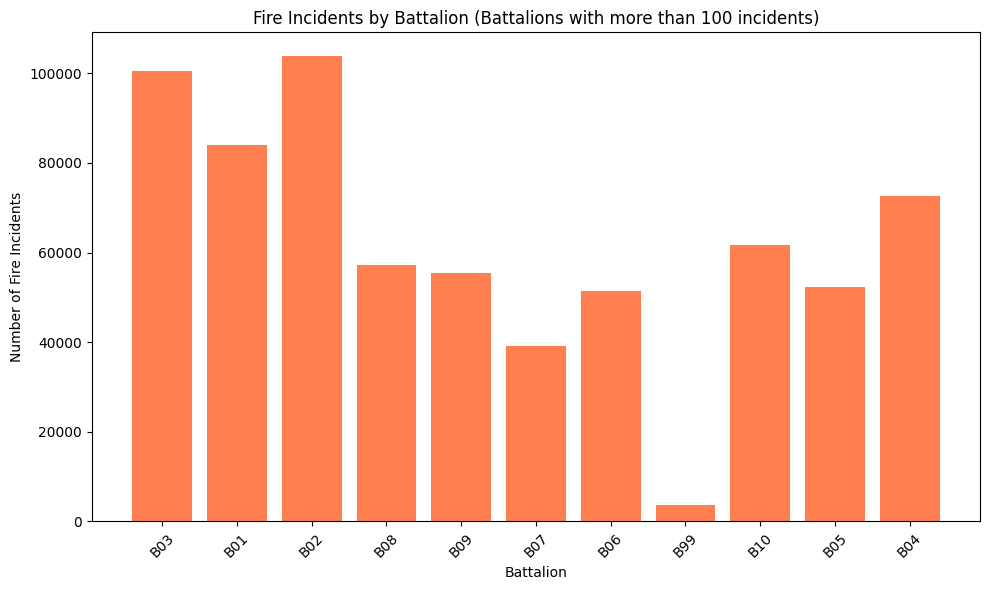

In [15]:
# Plotting the number of fire incidents by battalion
plt.figure(figsize=(10, 6))
plt.bar(result_battalion_df['battalion'], result_battalion_df['incident_count'], color='coral')
plt.xlabel('Battalion')
plt.ylabel('Number of Fire Incidents')
plt.title(f'Fire Incidents by Battalion (Battalions with more than 100 incidents)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'fire_incidents_by_battalion.png')
plt.show()
